### Prof. Pedram Jahangiry

You need to make a copy to your own Google drive if you want to edit the original notebook! Start by opening this notebook on Colab 👇

<a href="https://colab.research.google.com/github/PJalgotrader/Deep_forecasting-USU/blob/main/Lectures%20and%20codes/Module%206-%20Deep%20Neural%20Networks/Module6_DNN_intuition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



![logo](https://upload.wikimedia.org/wikipedia/commons/4/44/Huntsman-Wordmark-with-USU-Blue.gif#center)


## 🔗 Links

[![linkedin](https://img.shields.io/badge/LinkedIn-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pedram-jahangiry-cfa-5778015a)

[![Youtube](https://img.shields.io/badge/youtube_channel-1DA1F2?style=for-the-badge&logo=youtube&logoColor=white&color=FF0000)](https://www.youtube.com/channel/UCNDElcuuyX-2pSatVBDpJJQ)

[![Twitter URL](https://img.shields.io/twitter/url/https/twitter.com/PedramJahangiry.svg?style=social&label=Follow%20%40PedramJahangiry)](https://twitter.com/PedramJahangiry)


---


# Module 6- DNN intuition

# Installation

* If you want to run your code on Google Colab, there is no installation required. (recommended for the course)
* If you want to run your code locally, then you need to install tensorflow first: https://www.tensorflow.org/install


Let's talk about the DNN intuition for timeseries, and see why is it not enough for simple ts modeling.
- say, we are working with the airline passenger data again and want to use only 1 lag!!!

In [1]:
import tensorflow
tensorflow.__version__

'2.17.0'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/airline_passengers.csv", index_col="Month")
data.index = pd.to_datetime(data.index)
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Making supervised ML/DL data

In [4]:
test_period = 24
train_period = len(data) - test_period

print(f"Train period: {train_period}")
print(f"Test period: {test_period}")

Train period: 120
Test period: 24


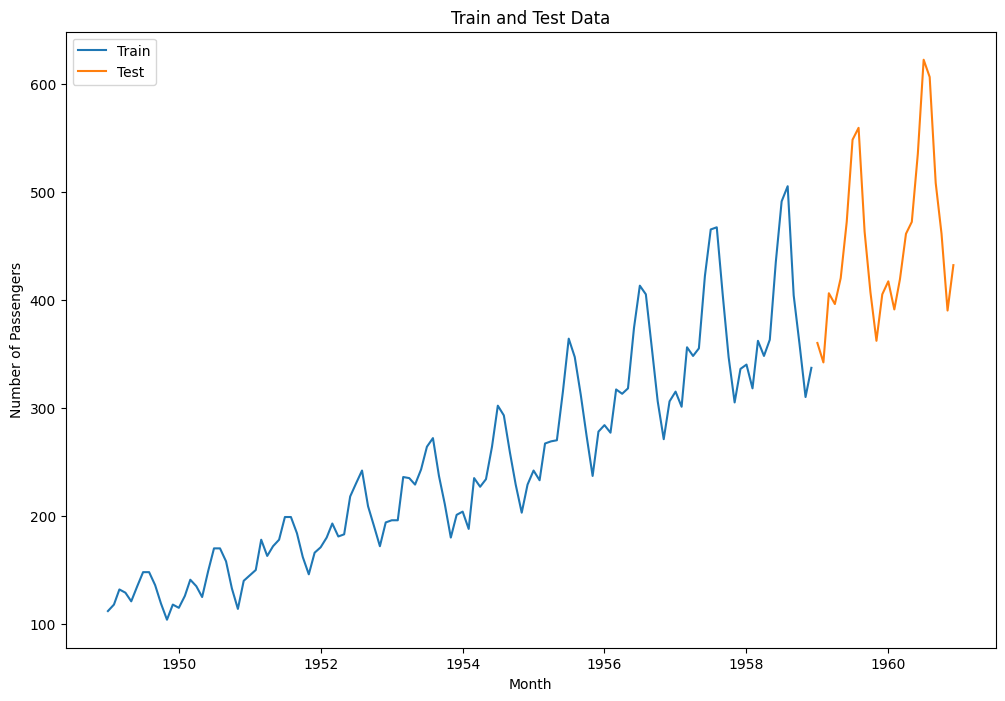

In [5]:
train = data.iloc[:train_period]
test = data.iloc[train_period:]

# plotting the train and test data with different colors
plt.figure(figsize=(12, 8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.title('Train and Test Data')
plt.xlabel('Month')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

In [6]:
# A Boolean series indicating which rows of the DataFrame data belong to each set (train, test)
train_indicator = (data.index <= train.index[-1])
test_indicator =  (data.index > train.index[-1])

# creating feature space X and target variable y for the training and test datasets
series = data['Passengers'].dropna().to_numpy()

In [7]:
Tx = 1 # Number of lags! using the past Tx observations to forecast the next one.
Ty = 1 #  Forecasting Ty outputs at once
X = np.array([series[t:t+Tx] for t in range(len(series) - Tx-Ty+1)])
Y = np.array([series[t+Tx: t+Tx+Ty] for t in range(len(series) - Tx-Ty+1)])
N = len(X)

print("X:", X.shape, "Y:", Y.shape, "N:", N)

X: (143, 1) Y: (143, 1) N: 143


In [21]:
Xtrain, Ytrain = X[:-test_period], Y[:-test_period]
Xtest, Ytest = X[-test_period:], Y[-test_period:]

# printing shapes
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

(119, 1) (119, 1) (24, 1) (24, 1)


Before doing a DNN model, let's visualize how a simple linear regression model (a DNN with no hidden layers) work!
let's visualize a simple model: $$y_t = b_0 + w_1 y_{t-1} + \epsilon_t $$


visualizing the network: https://alexlenail.me/NN-SVG/index.html

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepWARNING:tensorflow:5 out of the last 16 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000025BE86CC700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


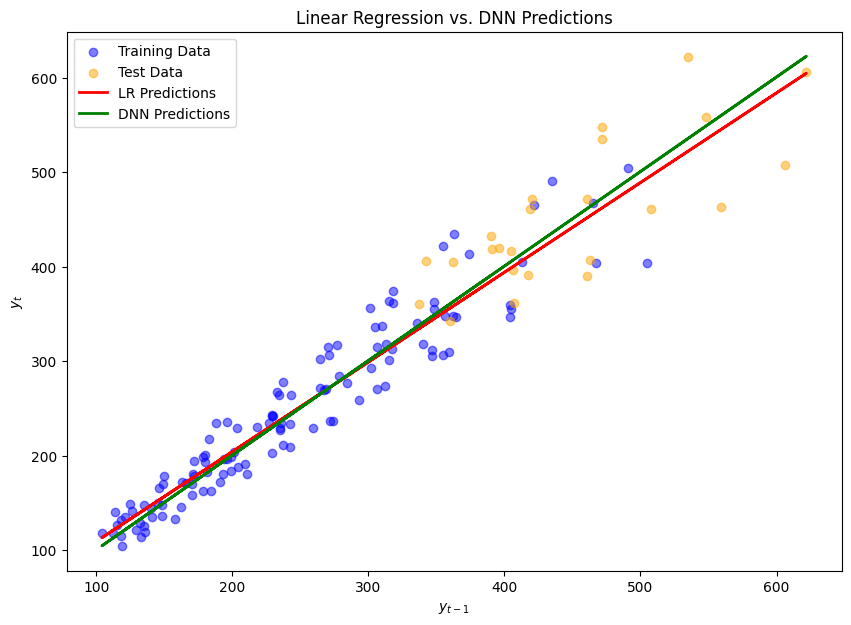

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Assume Xtrain, Ytrain, Xtest, Ytest have been properly prepared

# Fit the Linear Regression Model
lr = LinearRegression()
lr.fit(Xtrain.reshape(-1, 1), Ytrain)  # Fit model to training data

# Fit the DNN Model
model_DNN = Sequential([
    #Dense(4, activation='relu', input_shape=(1,)),
    #Dense(8, activation='relu'),
    Dense(1, activation='linear')
])
model_DNN.compile(optimizer='adam', loss='mse')
model_DNN.fit(Xtrain.reshape(-1, 1), Ytrain, epochs=200, batch_size=16, validation_split=0.1, verbose=0)  # Train model

# Prepare combined X for predictions (train + test)
X_combined = np.vstack((Xtrain, Xtest)).reshape(-1, 1)

# Generate predictions across combined dataset
predictions_lr_combined = lr.predict(X_combined)
predictions_dnn_combined = model_DNN.predict(X_combined).flatten()

# Setting up the 2D plot
plt.figure(figsize=(10, 7))

# Scatter plot for training and test actuals
plt.scatter(Xtrain, Ytrain, color='blue', alpha=0.5, label='Training Data')
plt.scatter(Xtest, Ytest, color='orange', alpha=0.5, label='Test Data')

# Prediction lines
plt.plot(X_combined, predictions_lr_combined, color='red', label='LR Predictions', linewidth=2)
plt.plot(X_combined, predictions_dnn_combined, color='green', label='DNN Predictions', linewidth=2)

plt.xlabel('$y_{t-1}$')
plt.ylabel('$y_t$')
plt.title('Linear Regression vs. DNN Predictions')
plt.legend()
plt.show()


In [29]:
# printing the coefficients of the linear regression model
print("Linear Regression Coefficients:")
print("Intercept:", lr.intercept_)
print("Coefficient:", lr.coef_[0])


Linear Regression Coefficients:
Intercept: [14.26426657]
Coefficient: [0.94952531]


In [30]:
model_DNN.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8 (36.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6 (28.00 B)

In [31]:
# Printing the weights of the DNN model
print("DNN Model Weights:")
print(model_DNN.get_weights())


DNN Model Weights:
[array([[1.0007617]], dtype=float32), array([0.35567752], dtype=float32)]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


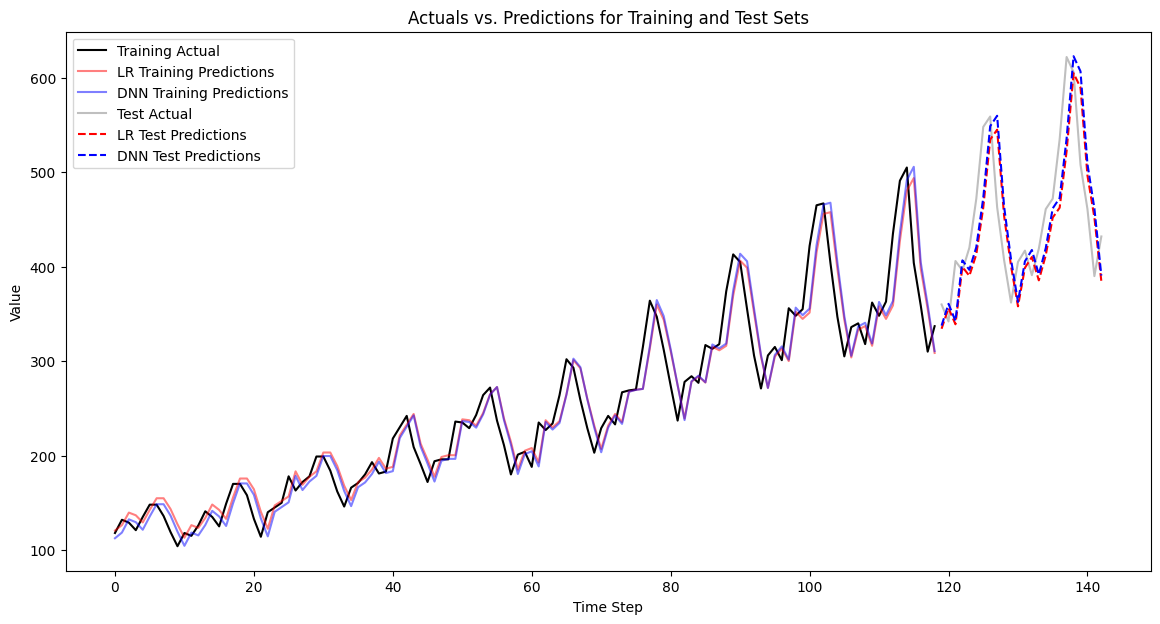

In [32]:

# Extract actual vs. predicted values for training and testing sets separately
actual_train = Ytrain
predictions_lr_train = lr.predict(Xtrain.reshape(-1, 1))
predictions_dnn_train = model_DNN.predict(Xtrain.reshape(-1, 1)).flatten()

actual_test = Ytest
predictions_lr_test = lr.predict(Xtest.reshape(-1, 1))
predictions_dnn_test = model_DNN.predict(Xtest.reshape(-1, 1)).flatten()


# Plotting Actuals vs Predictions in a single plot
plt.figure(figsize=(14, 7))

# Training Data
plt.plot(range(len(actual_train)), actual_train, color='black', label='Training Actual')
plt.plot(range(len(predictions_lr_train)), predictions_lr_train, color='red', alpha= 0.5, label='LR Training Predictions', )
plt.plot(range(len(predictions_dnn_train)), predictions_dnn_train, color='blue',alpha= 0.5, label='DNN Training Predictions')

# Test Data
# Note: Adjusting the range for test data to continue from the end of the training data
test_start = len(actual_train)
plt.plot(range(test_start, test_start + len(actual_test)), actual_test, color='grey', alpha=0.5, label='Test Actual')
plt.plot(range(test_start, test_start + len(predictions_lr_test)), predictions_lr_test, color='red', label='LR Test Predictions', linestyle='--')
plt.plot(range(test_start, test_start + len(predictions_dnn_test)), predictions_dnn_test, color='blue', label='DNN Test Predictions', linestyle='--')

plt.title('Actuals vs. Predictions for Training and Test Sets')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


Now let's visualize the same thing for stock!!

In [34]:
import yfinance as yf

In [37]:
# Note: as of Jan 2024, Yahoo finance has removed the adj close column. So we will be using the Close column instead.
aapl = yf.download('AAPL', start='2019-01-01')[['Close']]
aapl.head()

[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2019-01-02,37.708595
2019-01-03,33.952538
2019-01-04,35.401955
2019-01-07,35.323154
2019-01-08,35.996529


In [ ]:
# Convert the index to a datetime index if it's not already
aapl.index = pd.to_datetime(aapl.index)
# Infer the frequency of the dataset or set it to 'B' for business day frequency
aapl = aapl.asfreq('B')
# Fill any missing values that might have been introduced by setting the frequency. Obviously, the Fill forward method is going to be more appropriate. 
# but we are keeping thins simple and use simple interpolation. 
aapl['Close'] = aapl['Close'].interpolate()

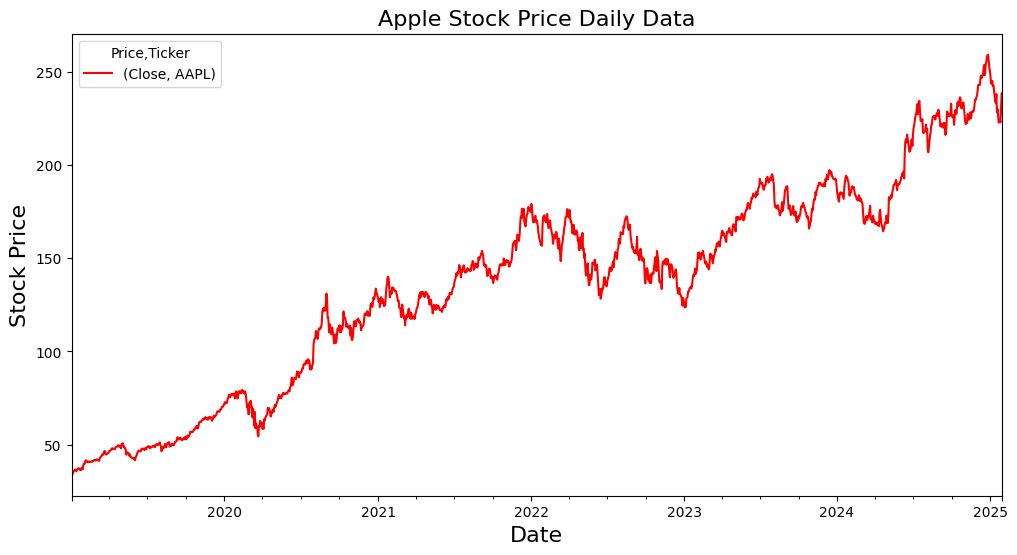

In [40]:
aapl.plot(figsize=(12,6), color='r')
# Add title
plt.title("Apple Stock Price Daily Data", fontsize=16)
# Add x and y label
plt.xlabel("Date", fontsize=16)
plt.ylabel("Stock Price", fontsize=16)

plt.show()

In [41]:
# creating feature space X and target variable y for the training and test datasets
series = aapl['Close'].dropna().to_numpy().flatten()
len(series)

1585

In [42]:
Tx = 1 # Number of lags! using the past Tx observations to forecast the next one.
Ty = 1 #  Forecasting Ty outputs at once
X = np.array([series[t:t+Tx] for t in range(len(series) - Tx-Ty+1)])
Y = np.array([series[t+Tx: t+Tx+Ty] for t in range(len(series) - Tx-Ty+1)])
N = len(X)

print("X:", X.shape, "Y:", Y.shape, "N:", N)

X: (1584, 1) Y: (1584, 1) N: 1584


In [43]:
Xtrain, Ytrain = X[:-test_period], Y[:-test_period]
Xtest, Ytest = X[-test_period:], Y[-test_period:]

# printing shapes
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

(1560, 1) (1560, 1) (24, 1) (24, 1)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step


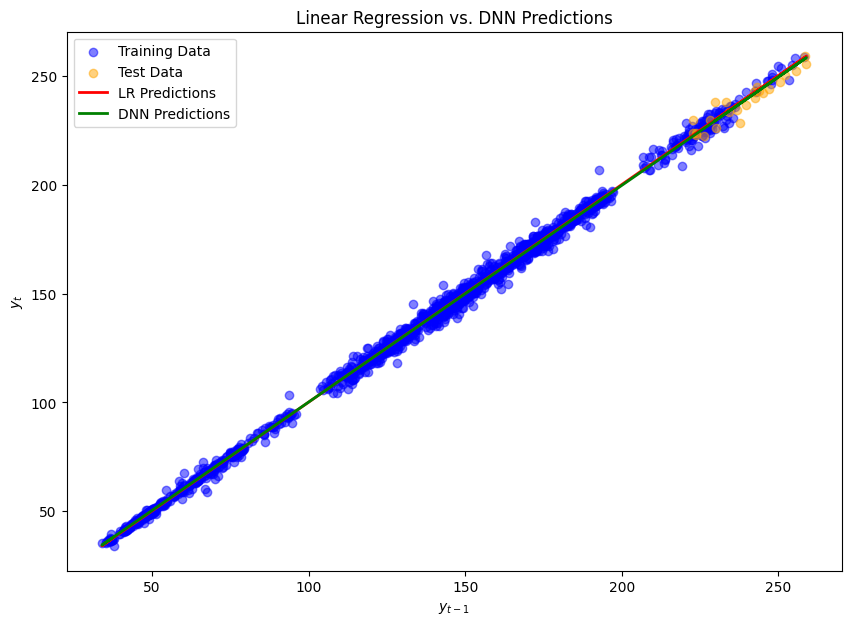

In [ ]:
# Fit the Linear Regression Model
lr = LinearRegression()
lr.fit(Xtrain.reshape(-1, 1), Ytrain)  # Fit model to training data

# Fit the DNN Model
model_DNN = Sequential([
    #Dense(4, activation='relu', input_shape=(1,)),
    #Dense(8, activation='relu'),
    Dense(1, activation='linear')
])
model_DNN.compile(optimizer='adam', loss='mse')
model_DNN.fit(Xtrain.reshape(-1, 1), Ytrain, epochs=100, batch_size=16, validation_split=0.1, verbose=0)  # Train model

# Prepare combined X for predictions (train + test)
X_combined = np.vstack((Xtrain, Xtest)).reshape(-1, 1)

# Generate predictions across combined dataset
predictions_lr_combined = lr.predict(X_combined)
predictions_dnn_combined = model_DNN.predict(X_combined).flatten()

# Setting up the 2D plot
plt.figure(figsize=(10, 7))

# Scatter plot for training and test actuals
plt.scatter(Xtrain, Ytrain, color='blue', alpha=0.5, label='Training Data')
plt.scatter(Xtest, Ytest, color='orange', alpha=0.5, label='Test Data')

# Prediction lines
plt.plot(X_combined, predictions_lr_combined, color='red', label='LR Predictions', linewidth=2)
plt.plot(X_combined, predictions_dnn_combined, color='green', label='DNN Predictions', linewidth=2)

plt.xlabel('$y_{t-1}$')
plt.ylabel('$y_t$')
plt.title('Linear Regression vs. DNN Predictions')
plt.legend()
plt.show()

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


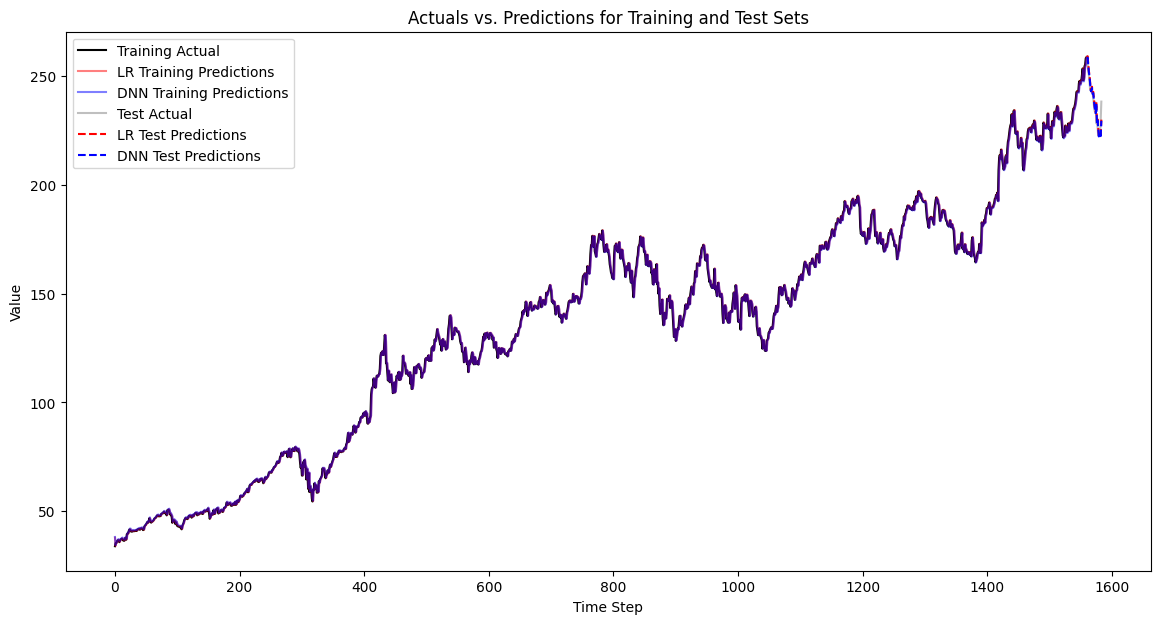

In [45]:
# Extract actual vs. predicted values for training and testing sets separately
actual_train = Ytrain
predictions_lr_train = lr.predict(Xtrain.reshape(-1, 1))
predictions_dnn_train = model_DNN.predict(Xtrain.reshape(-1, 1)).flatten()

actual_test = Ytest
predictions_lr_test = lr.predict(Xtest.reshape(-1, 1))
predictions_dnn_test = model_DNN.predict(Xtest.reshape(-1, 1)).flatten()


# Plotting Actuals vs Predictions in a single plot
plt.figure(figsize=(14, 7))

# Training Data
plt.plot(range(len(actual_train)), actual_train, color='black', label='Training Actual')
plt.plot(range(len(predictions_lr_train)), predictions_lr_train, color='red', alpha= 0.5, label='LR Training Predictions', )
plt.plot(range(len(predictions_dnn_train)), predictions_dnn_train, color='blue',alpha= 0.5, label='DNN Training Predictions')

# Test Data
# Note: Adjusting the range for test data to continue from the end of the training data
test_start = len(actual_train)
plt.plot(range(test_start, test_start + len(actual_test)), actual_test, color='grey', alpha=0.5, label='Test Actual')
plt.plot(range(test_start, test_start + len(predictions_lr_test)), predictions_lr_test, color='red', label='LR Test Predictions', linestyle='--')
plt.plot(range(test_start, test_start + len(predictions_dnn_test)), predictions_dnn_test, color='blue', label='DNN Test Predictions', linestyle='--')

plt.title('Actuals vs. Predictions for Training and Test Sets')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


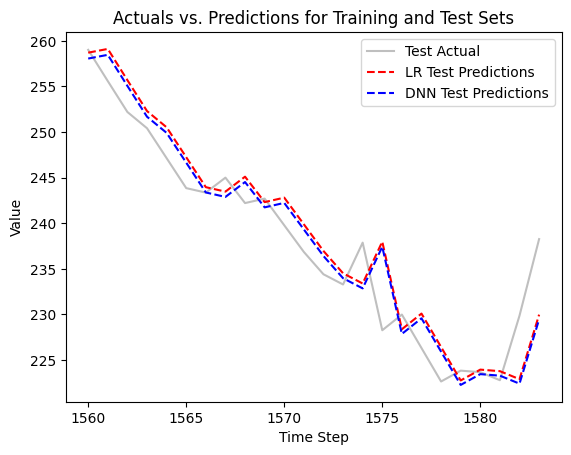

In [46]:
# Test Data
# Note: Adjusting the range for test data to continue from the end of the training data
test_start = len(actual_train)
plt.plot(range(test_start, test_start + len(actual_test)), actual_test, color='grey', alpha=0.5, label='Test Actual')
plt.plot(range(test_start, test_start + len(predictions_lr_test)), predictions_lr_test, color='red', label='LR Test Predictions', linestyle='--')
plt.plot(range(test_start, test_start + len(predictions_dnn_test)), predictions_dnn_test, color='blue', label='DNN Test Predictions', linestyle='--')

plt.title('Actuals vs. Predictions for Training and Test Sets')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

## Done!